In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from tqdm.notebook import tqdm
import datetime

from models.linear import Generator, Discriminator
from tools.viz import plot_anomalies, plot_single_var, plot_to_tensorboard, plot_anomaly_scores, plot_train_hist, plot_data_values
from tools.anomaly import madgan_reconstruction, madgan_reconstruction_discr_loss, feature_anomaly_score

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 32
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        self.method = "joint"
        self.scaler = MinMaxScaler((-1,1))
        # self.wsize = 5
        
        # Train params
        self.lr = 0.0002
        self.epochs = 25
        self.G_niters = 5
        self.D_niters = 10
        
        self.model_out = Path('./runs/linear/minmax/' + time_id + '_joint')
        self.train_plots = True

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        
        (self.model_out / "img").mkdir(exist_ok=True)
        
opts = Options()


# Setup Training Dataset

In [2]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=True,
    is_train=True,
    scaler=opts.scaler,
    # window_size=opts.wsize,
    # use_pca=True,
    # pca_scaler=StandardScaler(),
    # n_components=128   
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Removed 705 extreme values
Inputs shape: (11066, 1920)
Inputs head:
 [[-1.          0.96053081  0.96056031 ... -1.         -1.
  -1.        ]
 [-1.          0.97331674  0.97338166 ... -1.         -1.
  -1.        ]
 [-1.          0.98365185  0.9837307  ... -1.         -1.
  -1.        ]
 [-1.          0.94539212  0.94547067 ... -1.         -1.
  -1.        ]
 [-1.          0.97452728  0.97463029 ... -1.         -1.
  -1.        ]]


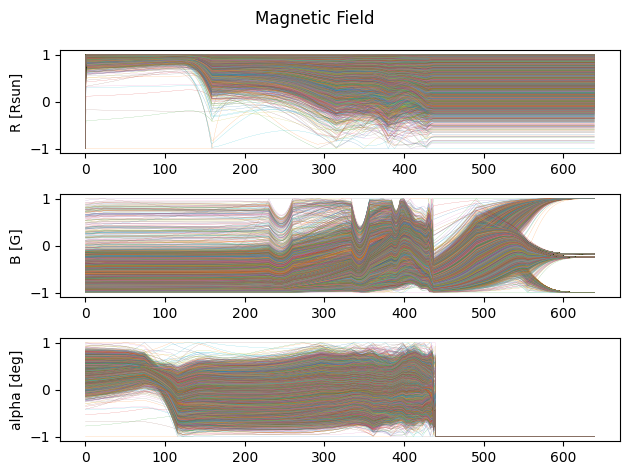

In [3]:
dataset.plot(title="Magnetic Field")

# Models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[1],
    hidden_size=1920,
    output_size=dataset.inputs.shape[1],
    nlower=4,
    neg_slope=0.2
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[1],
    hidden_size=1920,
    nlayers=2, 
    neg_slope=0.2
).to(device)

Using device:  cuda:0


In [5]:
netG.train()

Generator(
  (main): Sequential(
    (tl1): Linear(in_features=1920, out_features=960, bias=True)
    (tbn1): BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (tleaky1): LeakyReLU(negative_slope=0.2, inplace=True)
    (tl2): Linear(in_features=960, out_features=480, bias=True)
    (tbn2): BatchNorm1d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (tleaky2): LeakyReLU(negative_slope=0.2, inplace=True)
    (tl3): Linear(in_features=480, out_features=240, bias=True)
    (tbn3): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (tleaky3): LeakyReLU(negative_slope=0.2, inplace=True)
    (bl1): Linear(in_features=240, out_features=480, bias=True)
    (bbn1): BatchNorm1d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bleaky1): LeakyReLU(negative_slope=0.2, inplace=True)
    (bl2): Linear(in_features=480, out_features=960, bias=True)
    (bbn2): BatchNorm1d(960, eps=1e-05

In [6]:
netD.train()

Discriminator(
  (main): Sequential(
    (l1): Linear(in_features=1920, out_features=960, bias=True)
    (bn1): BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky1): LeakyReLU(negative_slope=0.2, inplace=True)
    (out): Linear(in_features=960, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [7]:
logger = SummaryWriter(f"logs/linear/{time_id}_D{netD.hidden_size}-L{netD.nlayers}_G{netG.hidden_size}-L{netG.nlower}")
logger.add_graph(netG, torch.randn(opts.batch_size, dataset.inputs.shape[1]).to(device))
logger.add_graph(netD, torch.randn(opts.batch_size, dataset.inputs.shape[1]).to(device))
logger.add_text("Generator", netG.__str__())
logger.add_text("Discriminator", netD.__str__())

2023-03-13 18:04:13.468265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.lr)

In [9]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for i, (x, _filename) in tqdm(enumerate(dataloader), desc=f"Epoch [{epoch}/{opts.epochs}]", total=len(dataloader), leave=False):
        
        # Format batch
        real = x.to(device)
        b_size, seq_len = real.size(0), real.size(1)
        real_labels = torch.full((b_size, 1), real_label, dtype=torch.float, device=device)
        
        # Train discriminator network to maximize log(D(x)) + log(1 - D(G(z)))
        for _ in range(opts.D_niters):
            netD.zero_grad()
            
            # Train with real batch
            output = netD(real)
            errD_real = criterion(output, real_labels)
            errD_real.backward()
            
            # Train with fake batch
            fake = netG(torch.randn_like(real, device=device))
            fake_labels = torch.full((b_size, 1), fake_label, dtype=torch.float, device=device)
            
            output = netD(fake.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
        D_losses.append(errD.item())
        
        # Train generator network to maximize log(D(G(z)))
        for _ in range(opts.G_niters):
            netG.zero_grad()
            
            fake = netG(torch.randn_like(real, device=device))
            output = netD(fake)
            errG = criterion(output, real_labels)
            errG.backward()
            optimizerG.step()
        G_losses.append(errG.item())
        # send losses to tensorboard
        logger.add_scalars('Loss/train', {'G': errG.item(), 'D': errD.item()}, iters)
        iters += 1
        
    # Calculate epoch losses
    output = netD(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()
    
    fake = netG(torch.randn_like(real, device=device)).detach()
    output = netD(fake)
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    
    errD = errD_real + errD_fake
    errG = criterion(output, real_labels)

    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs,
                errD.item(), errG.item(), D_x, D_G_z1))

    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    if abs(errD-errG).item() < best_loss_dist and epoch > 2: 
        best_loss_dist = torch.abs(errD-errG).item()
        torch.save(netG.state_dict(), opts.model_out / 'Gbest.pth')
        torch.save(netD.state_dict(), opts.model_out / 'Dbest.pth')
        
        if opts.train_plots:
            fake = dataset.unscale(fake.detach().cpu().numpy())
            # fake = dataset.flatten(fake.detach().cpu().numpy())
            fig = plot_data_values(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scales={"alpha [deg]" : "linear"})
            fig.savefig(opts.model_out / f"img/{epoch}_best", dpi=200)
            plot_to_tensorboard(logger, fig, epoch, "train/best")
            plt.close(fig)
    elif epoch % 5 == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            # fake = dataset.flatten(fake.detach().cpu().numpy())
            fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_data_values(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scales={"alpha [deg]" : "linear"})
            fig.savefig(opts.model_out / f'img/inter_{epoch}.png', dpi=200)
            plot_to_tensorboard(logger, fig, epoch, "train/inter")
            plt.close(fig)
            
        train_f = plot_train_hist(D_losses, G_losses, opts.model_out)
        plt.close(train_f)
    

Starting Training Loop...


Epoch [0/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[0/25]	Loss_D: 0.7191	Loss_G: 1.2434	D(x): 0.7393	D(G(z)): 0.3064


Epoch [1/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[1/25]	Loss_D: 0.5994	Loss_G: 1.4741	D(x): 0.8049	D(G(z)): 0.2770


Epoch [2/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[2/25]	Loss_D: 0.8603	Loss_G: 1.1505	D(x): 0.7431	D(G(z)): 0.3892


Epoch [3/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[3/25]	Loss_D: 0.7492	Loss_G: 1.2113	D(x): 0.7834	D(G(z)): 0.3664


Epoch [4/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[4/25]	Loss_D: 0.8204	Loss_G: 1.3239	D(x): 0.7441	D(G(z)): 0.3491


Epoch [5/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[5/25]	Loss_D: 0.7814	Loss_G: 1.3785	D(x): 0.6945	D(G(z)): 0.2916


Epoch [6/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[6/25]	Loss_D: 0.9765	Loss_G: 1.0203	D(x): 0.6777	D(G(z)): 0.4012


Epoch [7/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[7/25]	Loss_D: 0.8980	Loss_G: 1.1719	D(x): 0.6985	D(G(z)): 0.3807


Epoch [8/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[8/25]	Loss_D: 1.0157	Loss_G: 1.0730	D(x): 0.6719	D(G(z)): 0.4114


Epoch [9/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[9/25]	Loss_D: 1.0929	Loss_G: 0.8492	D(x): 0.6727	D(G(z)): 0.4613


Epoch [10/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[10/25]	Loss_D: 0.9256	Loss_G: 0.9842	D(x): 0.7011	D(G(z)): 0.4024


Epoch [11/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[11/25]	Loss_D: 1.2048	Loss_G: 0.7425	D(x): 0.6349	D(G(z)): 0.4883


Epoch [12/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[12/25]	Loss_D: 0.8106	Loss_G: 1.2117	D(x): 0.6917	D(G(z)): 0.3319


Epoch [13/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[13/25]	Loss_D: 1.2007	Loss_G: 0.8394	D(x): 0.6540	D(G(z)): 0.4766


Epoch [14/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[14/25]	Loss_D: 1.3709	Loss_G: 0.7288	D(x): 0.5598	D(G(z)): 0.5082


Epoch [15/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[15/25]	Loss_D: 0.8356	Loss_G: 1.1119	D(x): 0.7407	D(G(z)): 0.3682


Epoch [16/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[16/25]	Loss_D: 1.0862	Loss_G: 0.9293	D(x): 0.6284	D(G(z)): 0.4230


Epoch [17/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[17/25]	Loss_D: 1.1919	Loss_G: 0.9045	D(x): 0.6018	D(G(z)): 0.4465


Epoch [18/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[18/25]	Loss_D: 1.0554	Loss_G: 1.0333	D(x): 0.6308	D(G(z)): 0.4055


Epoch [19/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[19/25]	Loss_D: 1.1092	Loss_G: 0.9604	D(x): 0.6164	D(G(z)): 0.4277


Epoch [20/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[20/25]	Loss_D: 1.0696	Loss_G: 0.9518	D(x): 0.6324	D(G(z)): 0.4182


Epoch [21/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[21/25]	Loss_D: 1.2945	Loss_G: 0.7694	D(x): 0.5806	D(G(z)): 0.4886


Epoch [22/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[22/25]	Loss_D: 1.0459	Loss_G: 1.1201	D(x): 0.5893	D(G(z)): 0.3680


Epoch [23/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[23/25]	Loss_D: 1.2715	Loss_G: 0.8887	D(x): 0.5587	D(G(z)): 0.4624


Epoch [24/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[24/25]	Loss_D: 0.9284	Loss_G: 1.0479	D(x): 0.6435	D(G(z)): 0.3657


In [10]:
logger.flush()

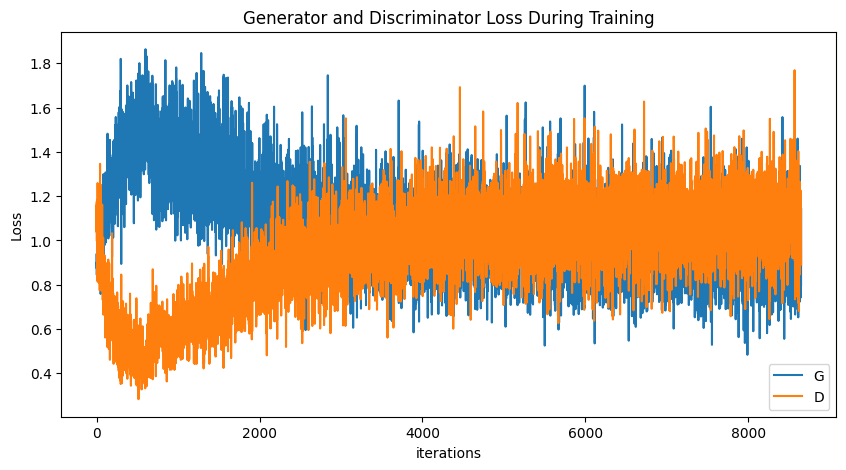

In [11]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Anomaly Detection

In [12]:

netD.train(True)
netG.train(True)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("./runs/multi/0313-1135_w20_madgan_pca320")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netG.load_state_dict(torch.load(opts_eval.models_dir / 'Gbest.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'Dbest.pth'))

<All keys matched successfully>

In [13]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Inputs shape: (11771, 1920)
Inputs head:
 [[-1.          0.96053081  0.96056031 ... -1.         -1.
  -1.        ]
 [-1.          0.97331674  0.97338166 ... -1.         -1.
  -1.        ]
 [-1.          0.98365185  0.9837307  ... -1.         -1.
  -1.        ]
 [-1.          0.94539212  0.94547067 ... -1.         -1.
  -1.        ]
 [-1.          0.97452728  0.97463029 ... -1.         -1.
  -1.        ]]


## Discriminator Classification

In [14]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs = netD(x.to(device))
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        # print(sample, filename)
        class_avg = sample[0]
        scores.append((filename, 1-class_avg.item()))

Anomaly Threshold:  0.9692651424556971
Found 1177 anomalies


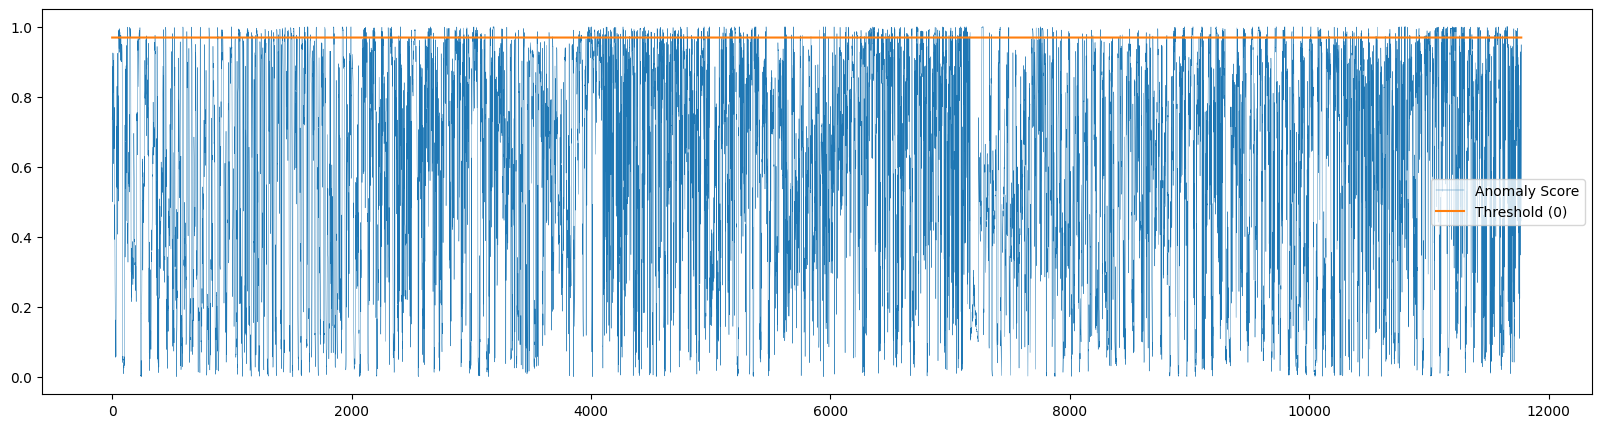

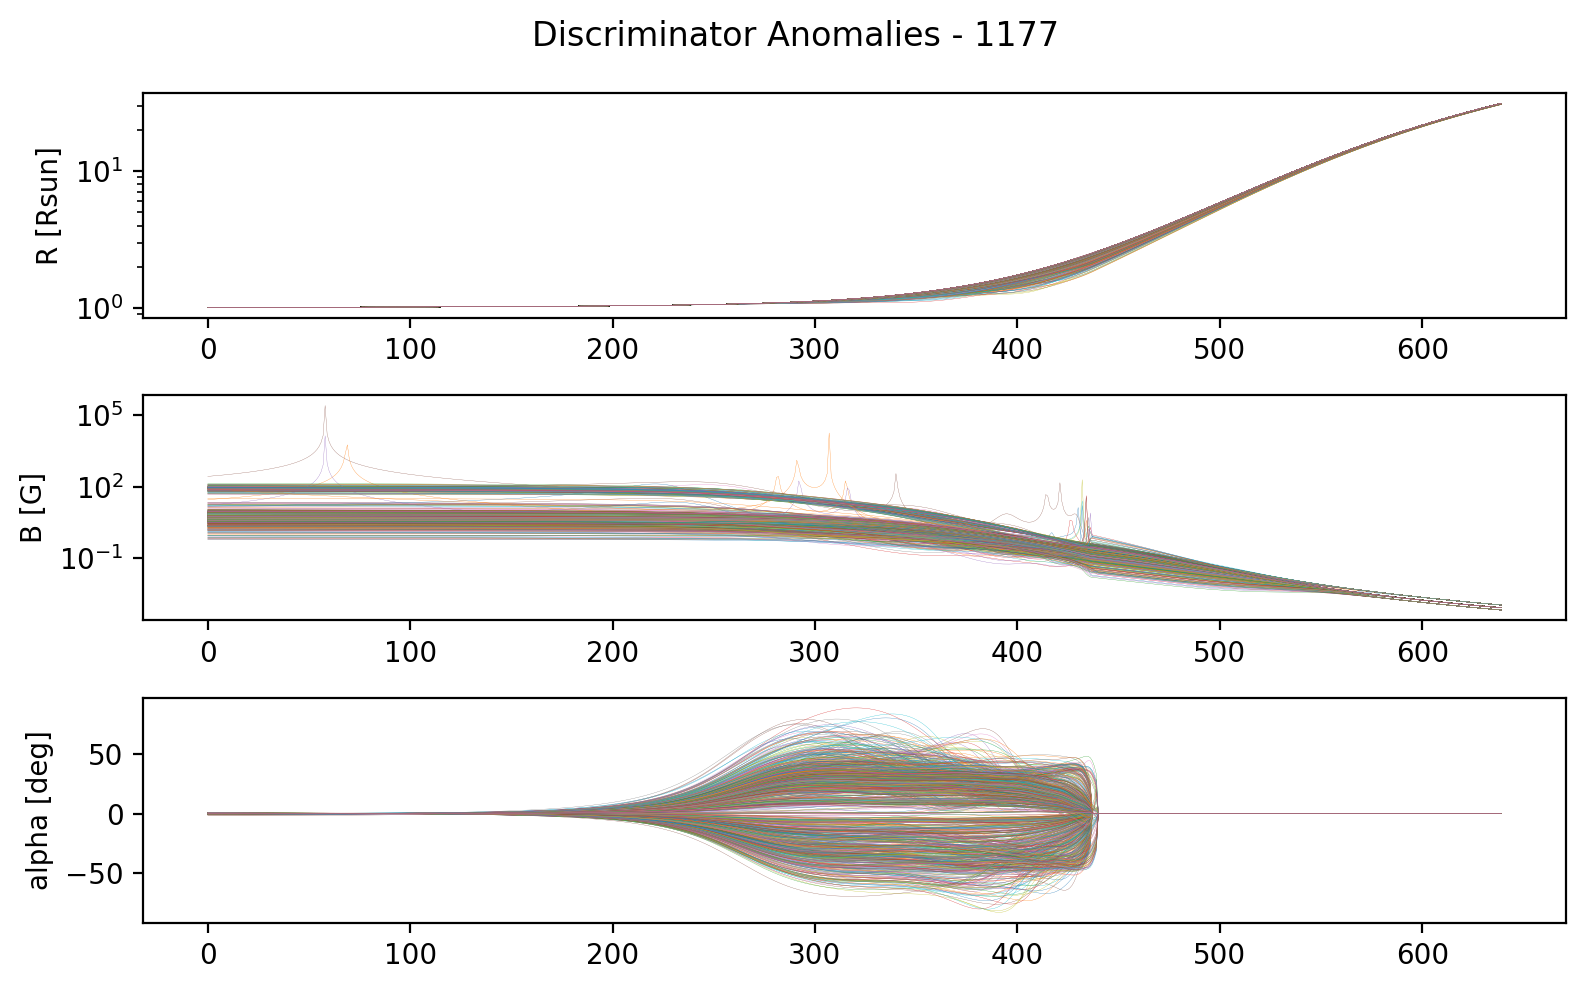

In [15]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/discr_scores",
                        scale="linear", method="Discriminator", logger=logger, logger_var="test/discr")

## Reconstruction Based

In [16]:
def reconstruction_anomaly_scores(dataloader, netG : nn.Module, netD : nn.Module, device : str,
                                  max_iters=100, reconstr_fn=madgan_reconstruction):
    mse_scores = []
    for i, (x, filenames) in enumerate(dataloader, 0):
        _z, loss = reconstr_fn(x, netG, netD, device, max_iters)
        # print(loss.shape)
        mse_scores.extend(zip(filenames, [l.mean().detach().cpu().numpy() for l in loss]))
        print(f"[{i}/{len(dataloader)}]", end='\r', flush=True)
        
    return mse_scores

### MSE Reconstruction

In [17]:
reconstr_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, opts_eval.niter, madgan_reconstruction)

Anomaly Threshold:  0.892965
Found 941 anomalies


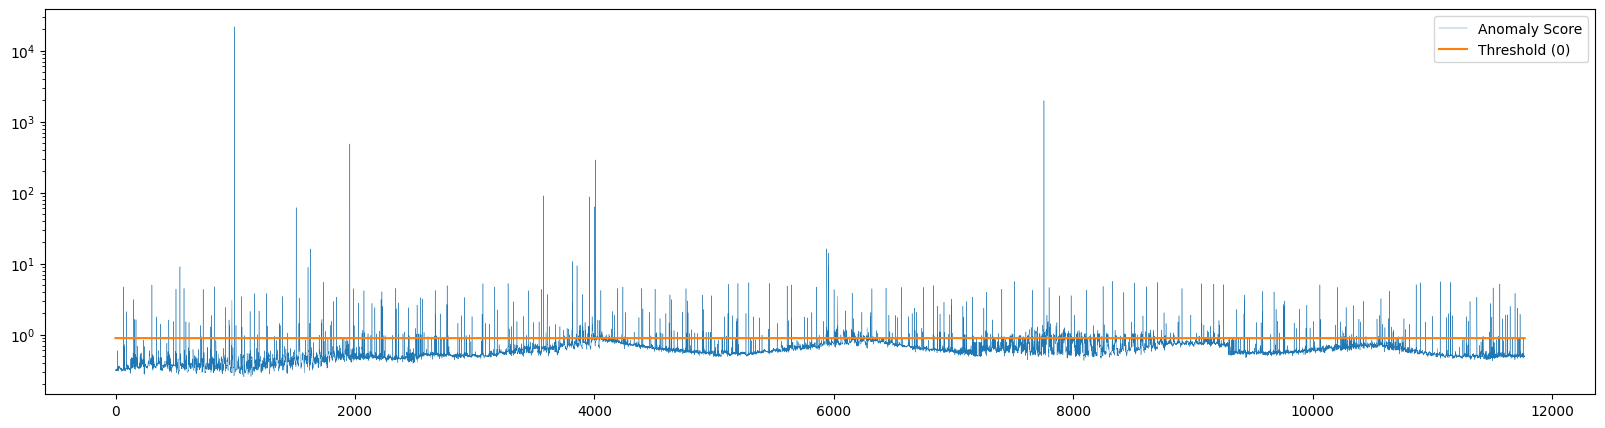

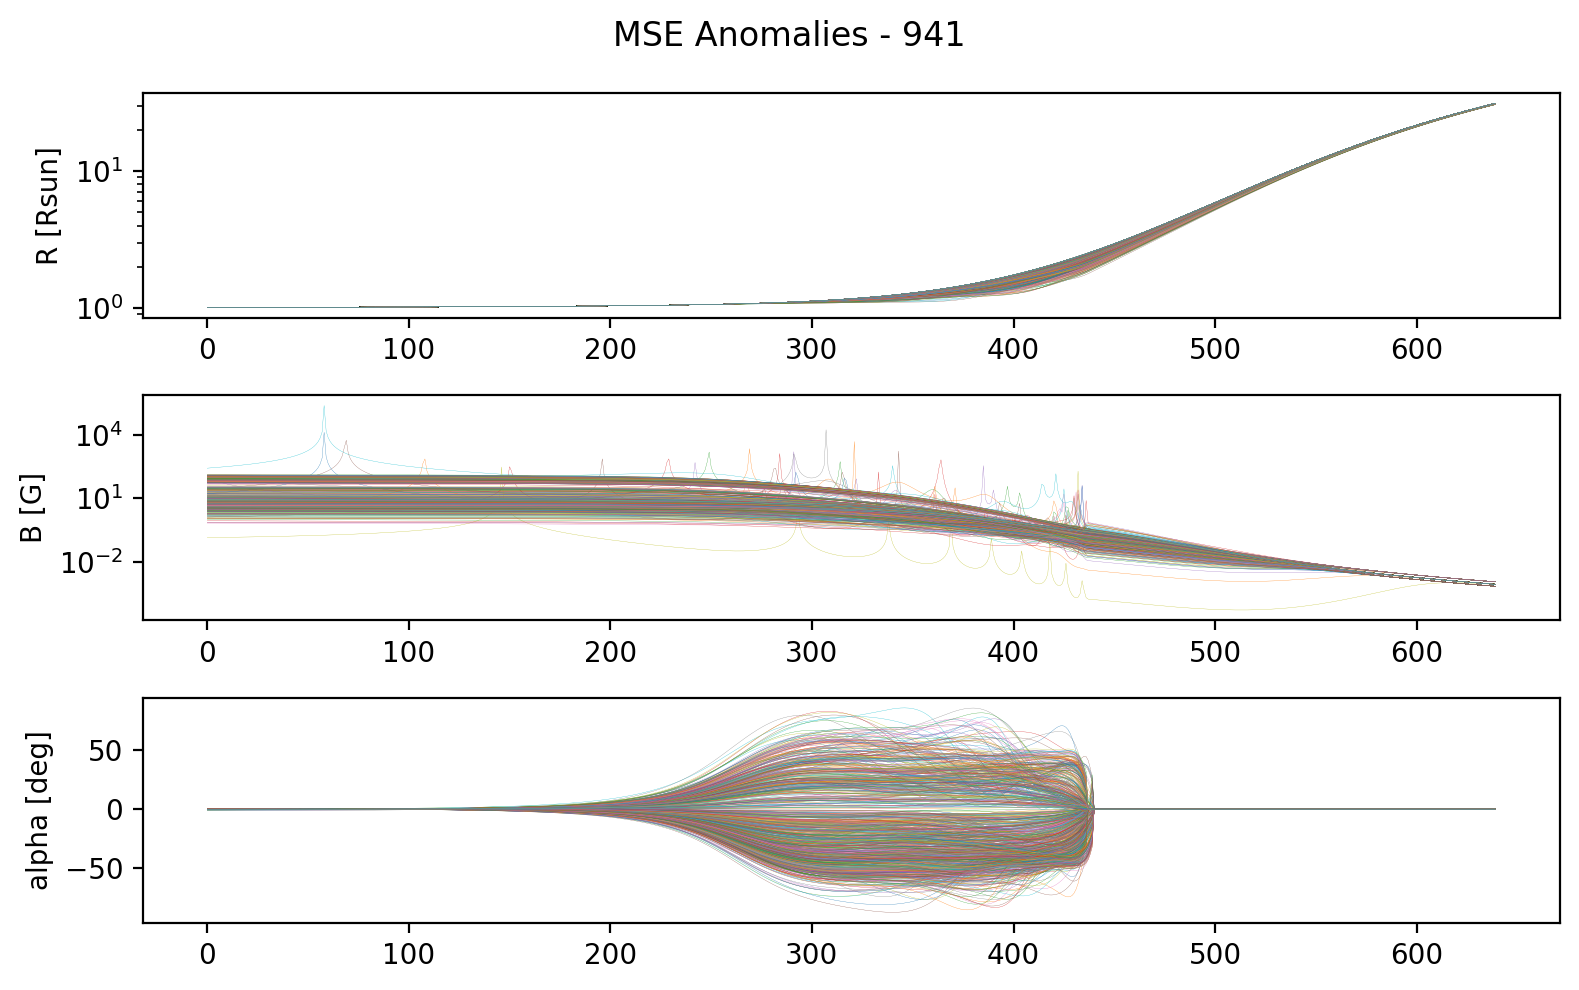

In [18]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores, 0.08, opts.data_path, opts_eval.models_dir /  f"img/mse", 
                        scale="log", method="MSE", logger=logger, logger_var="test/mse")

### MSE Reconstruction with Discriminator feedback

In [19]:
reconstr_scores_discr = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                      opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  0.17868395
Found 1177 anomalies


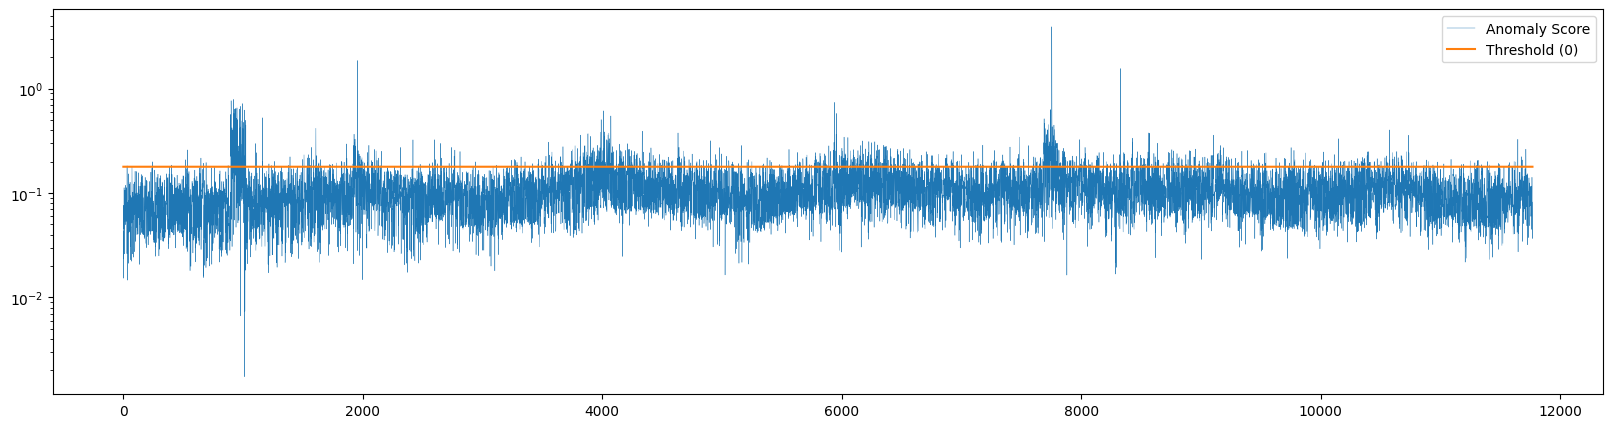

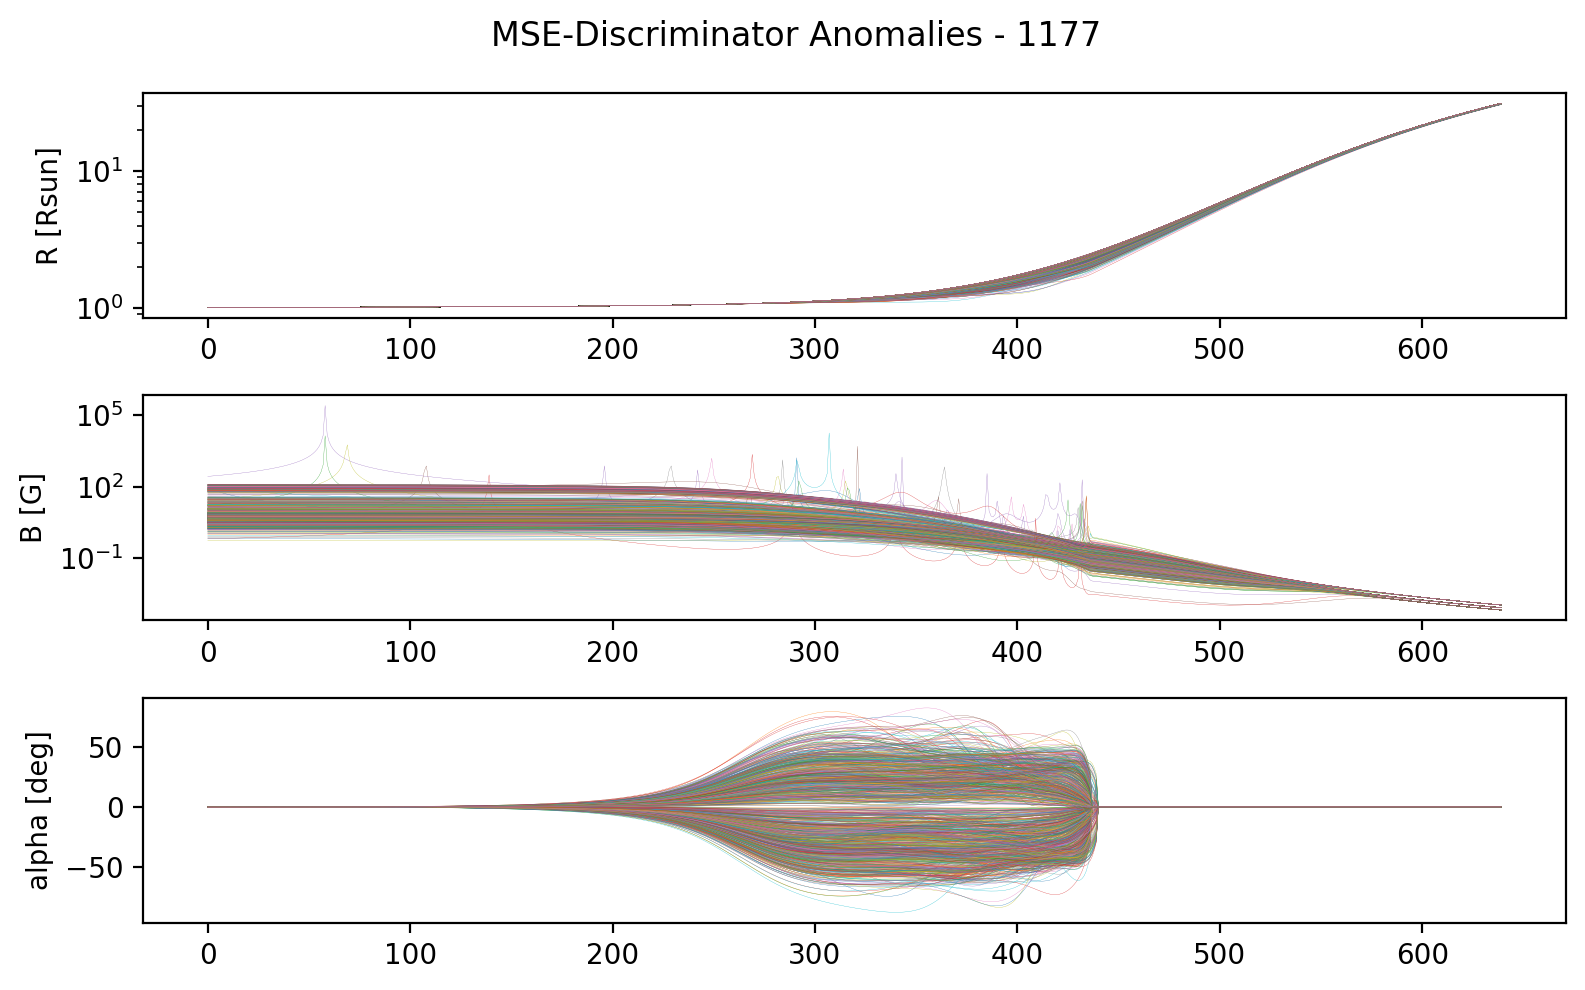

In [20]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores_discr, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_discr",
                        scale="log", method="MSE-Discriminator", logger=logger, logger_var="test/mse_discr")

### Feature Reconstruction

In [21]:
reconstr_feature_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                        opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  0.17877096
Found 1177 anomalies


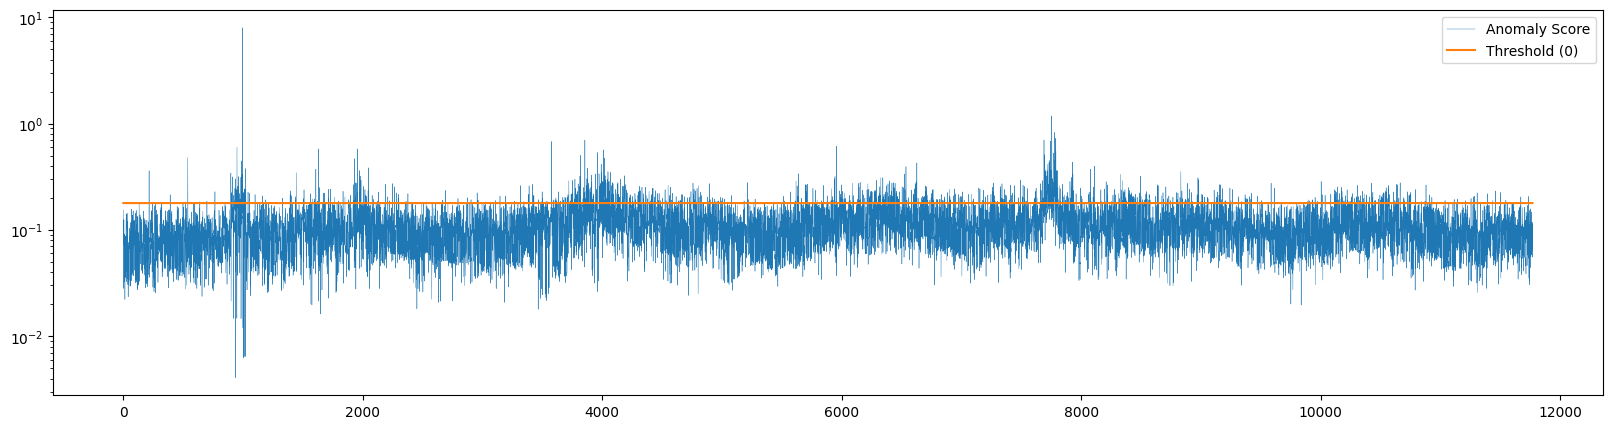

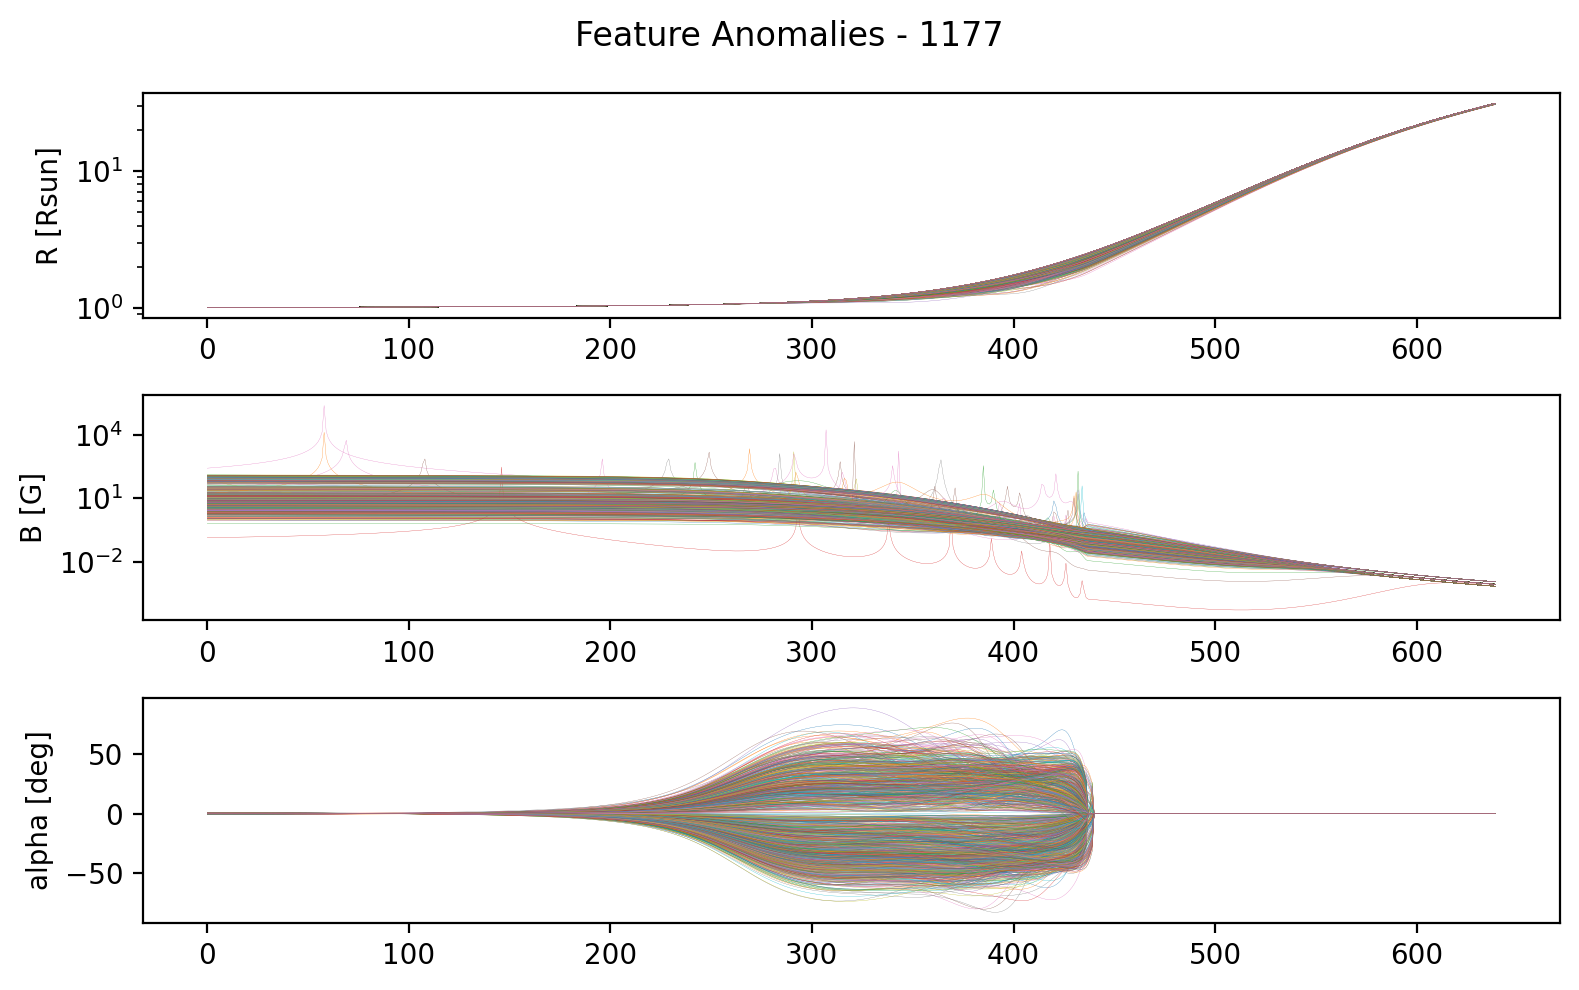

In [22]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_feature_scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_feature",
                        scale="log", method="Feature", logger=logger, logger_var="test/mse_feature")

In [23]:
logger.flush()